# ALS of Heidelberg - Height above ground

Notebook creator: Hannah Weiser, 2025

This demo uses a digital terrain model (DTM) of Heidelberg, Germany, which will be scanned by airborne laser scanning (ALS), maintaining a constant height above ground using interpolated trajectories.

In [31]:
from pathlib import Path
import helios
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import math
from scipy.interpolate import CubicSpline, make_interp_spline
import rasterio as rio

In [32]:
def interpolate_waypoints(t, x, y, time_step, b_spline_degree=3):
    """ Interpolates waypoints to create a smooth trajectory using cubic splines."""

    # Generate new time points
    new_t = np.arange(t[0], t[-1] + time_step, time_step)
    fx = make_interp_spline(t, x, b_spline_degree)
    fy = make_interp_spline(t, y, b_spline_degree)
    
    # Interpolate x and y
    new_x = fx(new_t)
    new_y = fy(new_t)

    return new_t, new_x, new_y


def compute_yaw_angles(x, y):
    yaw_angles = []
    for i in range(len(x) - 1):
        dx = x[i+1] - x[i]
        dy = y[i+1] - y[i]
        yaw = np.arctan2(dy, dx)
        # convert to degrees
        #yaw = np.degrees(yaw)
        # Normalize yaw to be in the range [0, 360°)
        if yaw < 0:
            yaw += 2 * np.pi
        # Append the yaw angle
        yaw_angles.append(yaw)
    
    # Append the last yaw angle
    yaw_angles.append(yaw_angles[-1])
    
    return np.array(yaw_angles)


def follow_height_above_ground(x, y, height_agl, dtm_file):
    coords = np.array([x, y]).T
    with rio.open(dtm_file) as src:
        z_vals = [z[0] + height_agl for z in src.sample(coords)]

    return np.array(z_vals)

## Creating the virtual scene

In [33]:
# load geotiff
dtm_file = "../data/sceneparts/tiff/dem_hd.tif"
dtm = helios.ScenePart.from_tiff(dtm_file)
# scene
scene = helios.StaticScene(scene_parts=[dtm])

## Scanner

In [34]:
scanner = helios.scanner_from_name("leica_als50")

## Survey Route

In [35]:
waypoints = np.array([
    [477280.4, 5472582.6],
    [480531.0, 5472590.9],
    [480553.9, 5473285.3],
    [477304.6, 5473277.0],
    [477313.5, 5473863.9],
    [480567.7, 5473888.6]
])

# compute time assuming constant speed
speed_m_s = 250
distances_between_waypoints = np.linalg.norm(np.diff(waypoints, axis=0), axis=1)
times = [0]
for distance in distances_between_waypoints:
    times.append(times[-1] + distance / speed_m_s)

In [36]:
# interpolate waypoints to create a trajectory
time_step = 0.2  # s
height_agl = 1000  # m
t, x, y = interpolate_waypoints(times, waypoints[:, 0], waypoints[:, 1], time_step=time_step, b_spline_degree=1)

z = follow_height_above_ground(x, y, height_agl, dtm_file)

roll = np.zeros(len(x))  # Assuming roll is zero for simplicity
pitch = np.zeros(len(x))  # Assuming pitch is zero for simplicity
yaw = compute_yaw_angles(x, y)
waypoints_final = np.zeros(len(x), dtype={'names':('t', 'roll', 'pitch', 'yaw', 'x', 'y', 'z'),
                                          'formats':('f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8')})
waypoints_final['x'] = x
waypoints_final['y'] = y
waypoints_final['z'] = z
waypoints_final['t'] = t
waypoints_final['roll'] = roll
waypoints_final['pitch']= pitch
waypoints_final['yaw'] = yaw

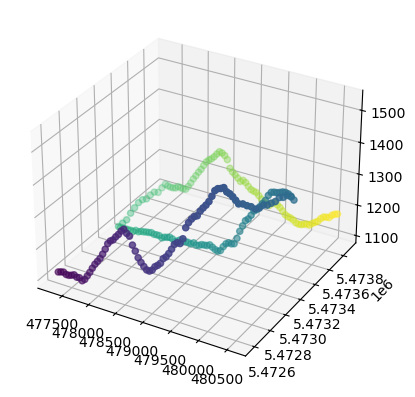

In [37]:
# plot trajectory
ax = plt.figure().add_subplot(projection='3d')
ax.scatter(waypoints_final['x'], waypoints_final['y'], waypoints_final['z'], 'ro-', label='Trajectory', c=waypoints_final['t'])
plt.show()

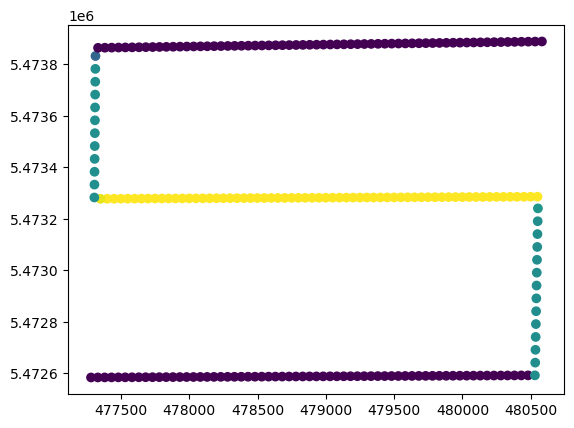

In [38]:
# plot from above coloured by yaw
plt.scatter(waypoints_final['x'], waypoints_final['y'], c=waypoints_final['yaw'])
plt.show()

In [45]:
waypoints_final

array([( 0. , 0., 0., 2.55336922e-03, 477280.4       , 5472582.6       , 1119.),
       ( 0.2, 0., 0., 2.55336922e-03, 477330.39983701, 5472582.72766832, 1122.),
       ( 0.4, 0., 0., 2.55336922e-03, 477380.39967402, 5472582.85533664, 1124.),
       ( 0.6, 0., 0., 2.55336920e-03, 477430.39951102, 5472582.98300497, 1119.),
       ( 0.8, 0., 0., 2.55336923e-03, 477480.39934803, 5472583.11067329, 1119.),
       ( 1. , 0., 0., 2.55336922e-03, 477530.39918504, 5472583.23834161, 1122.),
       ( 1.2, 0., 0., 2.55336920e-03, 477580.39902205, 5472583.36600993, 1126.),
       ( 1.4, 0., 0., 2.55336922e-03, 477630.39885905, 5472583.49367825, 1121.),
       ( 1.6, 0., 0., 2.55336922e-03, 477680.39869606, 5472583.62134658, 1122.),
       ( 1.8, 0., 0., 2.55336920e-03, 477730.39853307, 5472583.7490149 , 1115.),
       ( 2. , 0., 0., 2.55336923e-03, 477780.39837008, 5472583.87668322, 1122.),
       ( 2.2, 0., 0., 2.55336920e-03, 477830.39820709, 5472584.00435154, 1136.),
       ( 2.4, 0., 0., 2.5533

# Platfrom and scanner settings

In [40]:
from helios.platforms import Platform
platform = Platform.load_interpolate_platform(
    waypoints_final,
    "data/platforms.xml",
    "sr22",
    interpolation_method="CANONICAL")

In [41]:
scanner_settings = helios.ScannerSettings(pulse_frequency=83_000 * helios.units.Hz,
                                          scan_frequency=50 * helios.units.Hz,
                                          scan_angle=30 * helios.units.deg,
                                          head_rotation="0 deg/s",
                                          trajectory_time_interval=0.06 * helios.units.s
                                         )
trajectory_settings = helios.platforms.TrajectorySettings(start_time=0, end_time=waypoints_final['t'][-1])

In [42]:
survey = helios.Survey(scanner=scanner, platform=platform, scene=scene)
survey.add_leg(scanner_settings=scanner_settings, trajectory_settings=trajectory_settings)

## Executing the survey

In [43]:
points, trajectory = survey.run(verbosity=helios.LogVerbosity.VERBOSE)

RuntimeError: allMeasurements is null or empty

In [ ]:
points["position"]

array([[4.78448007e+05, 5.47296971e+06, 1.24389977e+02],
       [4.78455799e+05, 5.47279948e+06, 2.00793649e+02],
       [4.78446595e+05, 5.47299220e+06, 1.22322812e+02],
       ...,
       [4.78220941e+05, 5.47363378e+06, 1.80445537e+02],
       [4.78108256e+05, 5.47335354e+06, 1.05487676e+02],
       [4.78109661e+05, 5.47335779e+06, 1.05193739e+02]],
      shape=(1731862, 3))

In [ ]:
trajectory["position"]

array([[4.78335126e+05, 5.47388789e+06, 3.07502553e+02],
       [4.78335126e+05, 5.47388789e+06, 3.07502553e+02],
       [4.78335126e+05, 5.47388789e+06, 3.07502553e+02],
       ...,
       [4.78335126e+05, 5.47388789e+06, 3.07507590e+02],
       [4.78335126e+05, 5.47388789e+06, 3.07507590e+02],
       [4.78335126e+05, 5.47388789e+06, 3.07507590e+02]], shape=(737, 3))

## Visualizing the results

Now we can display a couple of 2D plots of the simulated point cloud.

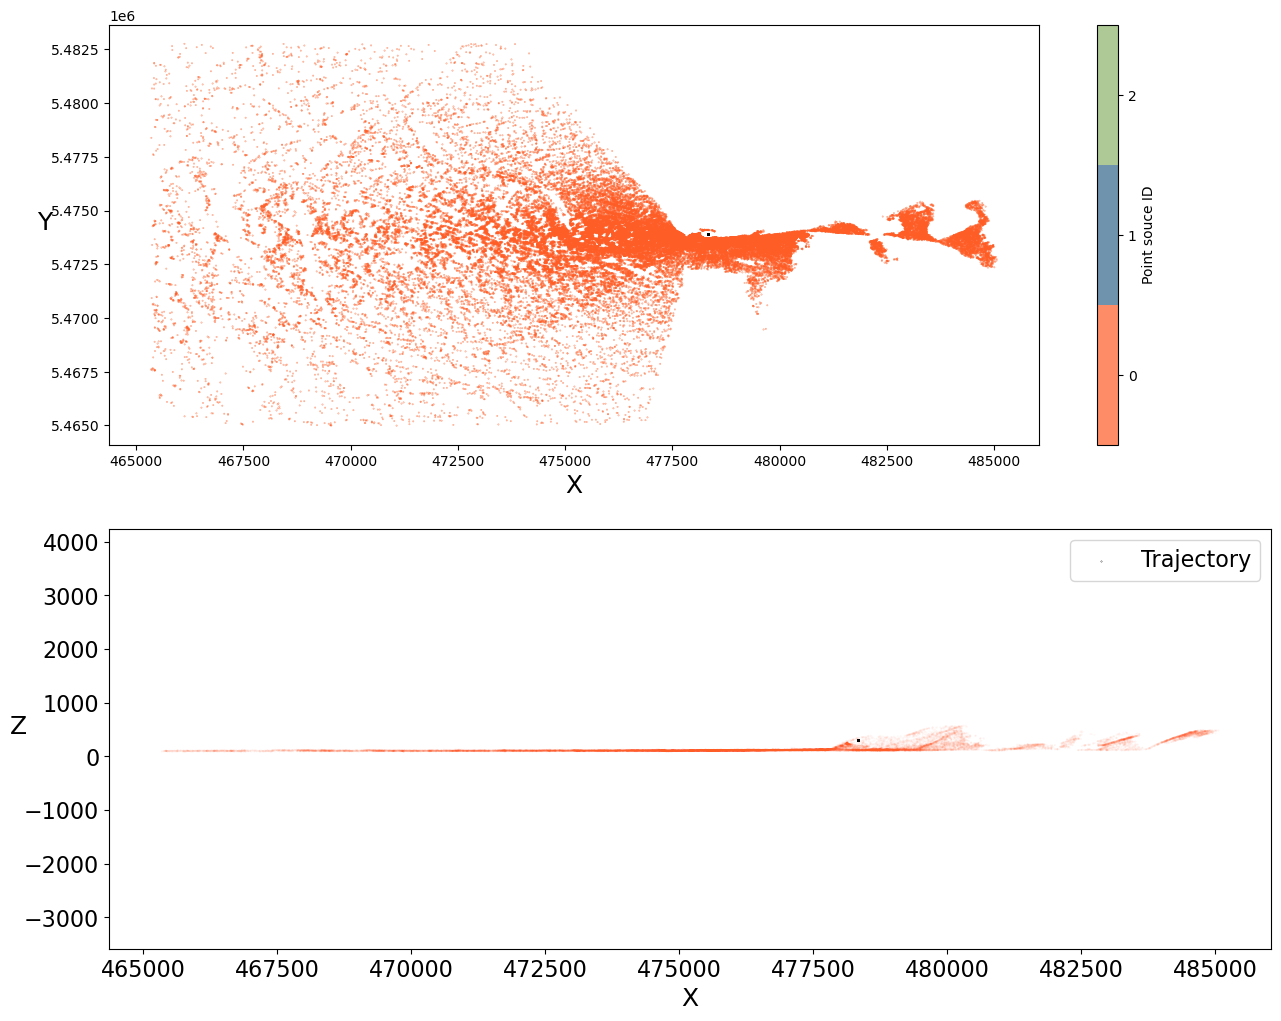

In [ ]:
# two subplots
fig, (ax1, ax2) = plt.subplots(2, figsize=(15, 12))
pos = points["position"]
traj = trajectory["position"]

N = 3
colors = ["#FE5D26", "#33658A", "#8CB369"]
rgba_colors = [mcolors.to_rgba(c) for c in colors]
cmap = mcolors.ListedColormap(rgba_colors, name="custom")  # discrete colormap with 3 colors

# view from above, colored by strip, including trajectory - for faster display, show only every 25th measurement
sc = ax1.scatter(
    pos[::25, 0], pos[::25, 1], s=0.1, alpha=0.7, c=points["point_source_id"][::25], cmap=cmap,
    vmin=-0.5, vmax=N - 0.5
)
ax1.scatter(traj[:, 0], traj[:, 1], s=0.1, label="Trajectory", color="black")
#ax1.tick_params(labelsize=16)
ax1.set_xlabel("X", fontsize=18)
ax1.set_ylabel("Y", fontsize=18, rotation=0)

plt.colorbar(sc, ticks=[0, 1, 2], label="Point souce ID")

# use only every 50th measurement for better display
ax2.scatter(
    pos[::50, 0], pos[::50, 2], alpha=0.05, s=0.1, c=points["point_source_id"][::50], cmap=cmap,
    vmin=-0.5, vmax=N - 0.5
)  # select X and Z coordinates
ax2.scatter(traj[:, 0], traj[:, 2], s=0.05, label="Trajectory", color="black")
ax2.tick_params(labelsize=16)
ax2.set_xlabel("X", fontsize=18)
ax2.set_ylabel("Z", fontsize=18, rotation=0)
ax2.legend(fontsize=16)

plt.axis("equal")
plt.show()

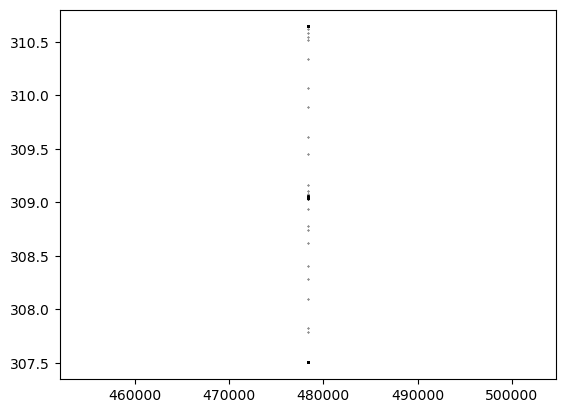

In [ ]:
#plt.scatter(traj[:, 0], traj[:, 1], s=0.1, label="Trajectory", color="black")
plt.scatter(traj[:, 0], traj[:, 2], s=0.1, label="Trajectory", color="black")
